In [1]:
import kagglehub
import pandas as pd
import os
from matplotlib import pyplot as plt
import networkx as nx

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("wjia26/epl-teams-twitter-sentiment-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/christofferfrost/.cache/kagglehub/datasets/wjia26/epl-teams-twitter-sentiment-dataset/versions/2


In [3]:
# Load both files
csv1 = os.path.join(path, "2020-07-09 till 2020-09-19.csv")
csv2 = os.path.join(path, "2020-09-20 till 2020-10-13.csv")
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Combine them into one DataFrame
df = pd.concat([df1, df2], ignore_index=True)
df = df[['created_at', 'file_name', 'username', 'text', 'retweet_count', 'polarity']]
df.columns = ['date', 'club', 'user', 'text', 'retweets', 'sentiment']
# Preview and basic info
print(df.shape)
df.head()


(1010582, 6)


,date,club,user,text,retweets,sentiment
0,2020-07-09 11:34:08,Liverpool,Liverpool FC News,This is a strange claim #LFC https://t.co/U1...,0,-0.2023
1,2020-07-09 11:33:52,Liverpool,Ged Smith,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,65,0.8316
2,2020-07-09 11:33:52,Liverpool,DADA BA♐,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,32,0.8793
3,2020-07-09 11:33:50,Liverpool,Ruairi Nolan,Outrageous... Poor auld Martin Tyler has to ju...,0,-0.6808
4,2020-07-09 11:33:31,Liverpool,🇮🇪 David D'Arcy 🇮🇪,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,176,0.8176


In [4]:
import pandas as pd
import numpy as np
import re
import requests
from io import StringIO

# -----------------------------
# 1. Download HTML (fix 403)
# -----------------------------
url = "https://en.wikipedia.org/wiki/List_of_English_football_transfers_summer_2020"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/124.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()
html = response.text

# -----------------------------
# 2. Read all HTML tables
# -----------------------------
tables = pd.read_html(StringIO(html))
print(f"Total tables found: {len(tables)}")

# -----------------------------
# 3. Keep only transfer-like tables
# -----------------------------
valid_tables = []

for t in tables:
    cols = [str(c).lower() for c in t.columns]

    has_date = any("date" in c for c in cols)
    has_from = any("from" in c for c in cols)
    has_to   = any("to"   in c for c in cols)

    if has_date and has_from and has_to:
        valid_tables.append(t)

print(f"Transfer-like tables kept: {len(valid_tables)}")

# Combine them into one DataFrame
transfers_df = pd.concat(valid_tables, ignore_index=True)

# Drop completely empty columns
transfers_df = transfers_df.dropna(axis=1, how="all")

# -----------------------------
# 4. Standardise column names
# -----------------------------
rename_map = {}
date_assigned   = False
player_assigned = False
from_assigned   = False
to_assigned     = False
fee_assigned    = False

for c in transfers_df.columns:
    cl = str(c).lower()

    if ("date" in cl) and not date_assigned:
        rename_map[c] = "Date"
        date_assigned = True
    elif ("player" in cl) and not player_assigned:
        rename_map[c] = "Player"
        player_assigned = True
    elif ("from" in cl) and not from_assigned:
        rename_map[c] = "From club"
        from_assigned = True
    elif ("to" in cl) and not to_assigned:
        rename_map[c] = "To club"
        to_assigned = True
    elif ("fee" in cl) and not fee_assigned:
        rename_map[c] = "Fee"
        fee_assigned = True

transfers_df = transfers_df.rename(columns=rename_map)

# Ensure unique columns only
transfers_df = transfers_df.loc[:, ~transfers_df.columns.duplicated()]

# Keep only meaningful columns
keep_cols = [c for c in ["Date", "Player", "From club", "To club", "Fee"] if c in transfers_df.columns]
transfers_df = transfers_df[keep_cols].copy()

print("Columns after cleaning:", transfers_df.columns.tolist())
print("Total raw rows:", len(transfers_df))

# -----------------------------
# 5. Clean and filter by date
# -----------------------------
transfers_df["Date"] = pd.to_datetime(transfers_df["Date"], dayfirst=True, errors="coerce")
transfers_df = transfers_df.dropna(subset=["Date"])

start_date = "2020-07-27"
end_date   = "2020-09-11"

mask_dates = (transfers_df["Date"] >= start_date) & (transfers_df["Date"] <= end_date)
window_df = transfers_df[mask_dates].copy()

print("Rows in date window:", len(window_df))

# -----------------------------
# 6. Keep only Premier League clubs (20/21)
# -----------------------------
pl_clubs = {
    "Arsenal",
    "Manchester United",
    "Liverpool",
    "Manchester City",
    "Tottenham Hotspur",
    "Everton",
    "Chelsea",
    "Crystal Palace",
    "Leicester City",
    "Southampton",
    "Burnley",
}


mask_pl = window_df["From club"].isin(pl_clubs) | window_df["To club"].isin(pl_clubs)
pl_transfers = window_df[mask_pl].copy()

print("Rows involving PL clubs:", len(pl_transfers))

# -----------------------------
# 7. Parse/clean fee column
# -----------------------------
def parse_fee_to_million_gbp(fee_str):
    if pd.isna(fee_str):
        return np.nan

    s = str(fee_str).lower().strip()

    if any(w in s for w in ["loan", "free", "undisclosed", "end of loan", "released"]):
        return 0.0

    s_clean = s.replace(",", "")

    m = re.search(r"£\s*([\d\.]+)\s*(m|million)", s_clean)
    if m:
        return float(m.group(1))

    k = re.search(r"£\s*([\d\.]+)\s*(k|thousand)", s_clean)
    if k:
        return float(k.group(1)) / 1000.0

    n = re.search(r"£\s*([\d\.]+)", s_clean)
    if n:
        return float(n.group(1)) / 1_000_000.0

    return np.nan

pl_transfers["Fee_clean_mGBP"] = pl_transfers["Fee"].apply(parse_fee_to_million_gbp)

# -----------------------------
# 8. Compute club expenditure
# -----------------------------
pl_buys = pl_transfers[pl_transfers["To club"].isin(pl_clubs)].copy()

club_spend = (
    pl_buys.groupby("To club")["Fee_clean_mGBP"]
    .sum()
    .sort_values(ascending=False)
)

print("\nTotal gross spend (million GBP):")
print(club_spend)

# -----------------------------
# 9. Save to CSV
# -----------------------------
pl_transfers.to_csv("pl_transfers_2020-07-27_to_2020-09-11.csv", index=False)
club_spend.to_csv("pl_club_spend_2020-07-27_to_2020-09-11.csv")

print("\nSaved:")
print(" - pl_transfers_2020-07-27_to_2020-09-11.csv")
print(" - pl_club_spend_2020-07-27_to_2020-09-11.csv")


Total tables found: 4
Transfer-like tables kept: 2
Columns after cleaning: ['Date', 'From club', 'To club', 'Fee']
Total raw rows: 819
Rows in date window: 361
Rows involving PL clubs: 55

Total gross spend (million GBP):
To club
Chelsea              116.00
Manchester City       61.87
Everton               53.70
Manchester United     35.00
Arsenal               27.00
Leicester City        25.00
Southampton           22.90
Crystal Palace        19.50
Tottenham Hotspur     15.00
Liverpool             11.75
Burnley                0.00
Name: Fee_clean_mGBP, dtype: float64

Saved:
 - pl_transfers_2020-07-27_to_2020-09-11.csv
 - pl_club_spend_2020-07-27_to_2020-09-11.csv


Filtered dataset (no matches): 446,475 rows, 6 columns
Size: 243.79 MB
Date range: 2020-07-27 00:00:02 → 2020-09-10 23:59:55
Unique clubs: 12

NETWORK OVERVIEW (no-match transfer window)
Nodes: 127,138 (Fans: 127,126, Clubs: 12)
Edges (fan↔club): 162,015

Top clubs by tweet count (no-match window):
                club  tweets  avg_sentiment  avg_retweets
1            Arsenal   79993       0.225329    201.126049
9   ManchesterUnited   78916       0.229009    320.193700
7          Liverpool   74239       0.271429    133.192204
8     ManchesterCity   50385       0.213904    450.954133
11  TottenhamHotspur   45118       0.211563    275.350060
5            Everton   35186       0.270679    106.048428
3            Chelsea   21931       0.194625    135.298390
4      CrystalPalace   21356       0.214788    116.098989
6      LeicesterCity   20254       0.187106    121.808680
10       Southampton    9456       0.220887     39.965842
0    AFC Bournemouth    6144       0.243267     22.740723
2   

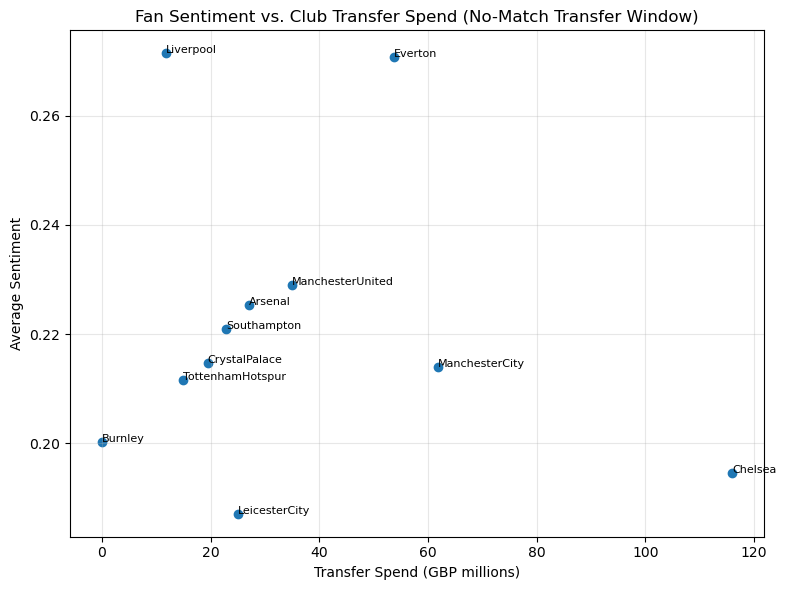

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os, re

# --- 1. Parse dates + drop obvious junk ---
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['club', 'user', 'text'])

# --- 2. Filter to NO-MATCH transfer window: 27 July 2020 – 11 September 2020 ---
start = pd.to_datetime("2020-07-27")  # day after 19/20 season ends
end   = pd.to_datetime("2020-09-11")  # day before 20/21 season starts

df = df[(df['date'] >= start) & (df['date'] <= end)].copy()

print(f"Filtered dataset (no matches): {len(df):,} rows, {df.shape[1]} columns")
print(f"Size: {round(df.memory_usage(deep=True).sum() / 1e6, 2)} MB")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print(f"Unique clubs: {df['club'].nunique()}")

# === 3. Build Fan–Club bipartite network (only from df) ===
G = nx.Graph()
for user, club in df[['user', 'club']].itertuples(index=False):
    if pd.isna(user) or pd.isna(club):
        continue
    G.add_node(user, bipartite='fan')
    G.add_node(club, bipartite='club')
    if G.has_edge(user, club):
        G[user][club]['weight'] += 1
    else:
        G.add_edge(user, club, weight=1)

fans = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'fan']
clubs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'club']

print("\nNETWORK OVERVIEW (no-match transfer window)")
print(f"Nodes: {G.number_of_nodes():,} (Fans: {len(fans):,}, Clubs: {len(clubs):,})")
print(f"Edges (fan↔club): {G.number_of_edges():,}")

# === 4. Average sentiment per club (in this window only) ===
club_sent = df.groupby('club', as_index=False).agg(
    tweets=('text', 'count'),
    avg_sentiment=('sentiment', 'mean'),
    avg_retweets=('retweets', 'mean')
).sort_values('tweets', ascending=False)

print("\nTop clubs by tweet count (no-match window):")
print(club_sent.head(12))

# === 5. Merge with transfer spend (manual CSV) ===
# Create a file 'transfer_spend.csv' with columns: club, spend_gbp_m
transfers_path = "pl_club_spend_2020-07-27_to_2020-09-11.csv"

if os.path.exists(transfers_path):
    spend = pd.read_csv(transfers_path)

    # Normalise column names a bit
    spend.columns = [c.strip().lower().replace(" ", "_") for c in spend.columns]
    # Now you should have: ['to_club', 'fee_clean_mgbp']

    # Rename to standard names for merging
    spend = spend.rename(columns={
        "to_club": "club",
        "fee_clean_mgbp": "spend_gbp_m"
    })

    def canon(s):
        return re.sub(r'[^a-z0-9]+', '', str(s).lower())

    # club_sent is your existing sentiment dataframe (with 'club' & 'avg_sentiment')
    club_sent['_key'] = club_sent['club'].apply(canon)
    spend['_key'] = spend['club'].apply(canon)

    merged = pd.merge(
        club_sent,
        spend,
        on='_key',
        how='inner',
        suffixes=('', '_spend')
    )

    # Prefer the club name from club_sent, fall back to the spend side if needed
    if 'club_spend' in merged.columns:
        merged['club'] = merged['club'].combine_first(merged['club_spend'])

    # Correlation
    corr = merged[['avg_sentiment', 'spend_gbp_m']].corr(method='pearson').iloc[0, 1]
    print(f"\nCorrelation between transfer spend and average sentiment (no-match window): {corr:.3f}")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(merged['spend_gbp_m'], merged['avg_sentiment'])
    for _, r in merged.iterrows():
        plt.text(r['spend_gbp_m'], r['avg_sentiment'], r['club'], fontsize=8)
    plt.xlabel('Transfer Spend (GBP millions)')
    plt.ylabel('Average Sentiment')
    plt.title('Fan Sentiment vs. Club Transfer Spend (No-Match Transfer Window)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️ Could not find 'pl_club_spend_2020-07-27_to_2020-09-11.csv' to correlate spend with sentiment.")


In [6]:
import numpy as np
import networkx as nx
import pandas as pd

# Safety: make sure we actually have nodes
if len(G) == 0:
    raise ValueError("Graph G is empty. Make sure you built it from df first.")

# --- Degree centrality (unweighted) ---
deg_cent = nx.degree_centrality(G)          # returns for all nodes
club_deg_cent = {c: deg_cent[c] for c in clubs}

# --- Weighted degree (strength): sum of edge weights (tweets) ---
club_strength = dict(G.degree(clubs, weight='weight'))

# --- Put into a DataFrame for easy sorting/printing ---
club_centrality_df = pd.DataFrame({
    "club": list(clubs),
    "degree_centrality": [club_deg_cent[c] for c in clubs],
    "strength": [club_strength[c] for c in clubs],
})

club_centrality_df = club_centrality_df.sort_values("degree_centrality", ascending=False)

print("Top clubs by degree centrality (no-match transfer window):")
print(club_centrality_df)


Top clubs by degree centrality (no-match transfer window):
                club  degree_centrality  strength
6            Arsenal           0.219275     80172
9   ManchesterUnited           0.214808     78916
5          Liverpool           0.213400     74241
7     ManchesterCity           0.164830     50385
8   TottenhamHotspur           0.141005     45118
11           Everton           0.079096     35255
0            Chelsea           0.065009     22070
10     CrystalPalace           0.057521     21356
2      LeicesterCity           0.054327     20254
4        Southampton           0.028426      9456
3    AFC Bournemouth           0.023746      6144
1            Burnley           0.013041      3497


In [7]:
# Degree centrality for fans
fan_deg_cent = {f: deg_cent[f] for f in fans}
fan_strength = dict(G.degree(fans, weight='weight'))

fan_cent_df = pd.DataFrame({
    "fan": list(fans),
    "degree_centrality": [fan_deg_cent[f] for f in fans],
    "strength": [fan_strength[f] for f in fans],
})

print("\nFan degree stats:")
print("Mean fan degree:", np.mean([G.degree(f) for f in fans]))
print("Mean fan strength:", np.mean(list(fan_strength.values())))
print("Max fan strength:", max(list(fan_strength.values())))



Fan degree stats:
Mean fan degree: 1.2742947941412457
Mean fan strength: 3.5090068121391376
Max fan strength: 3793


Average fan degree: 1.2742947941412457
Average fan strength: 3.5090068121391376


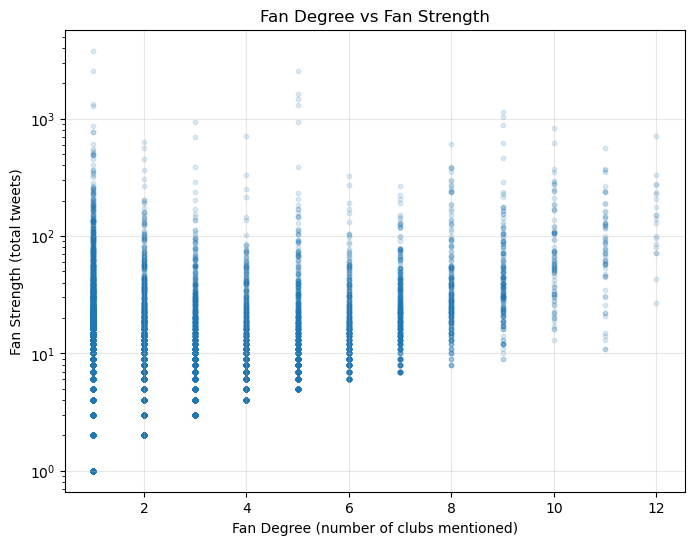

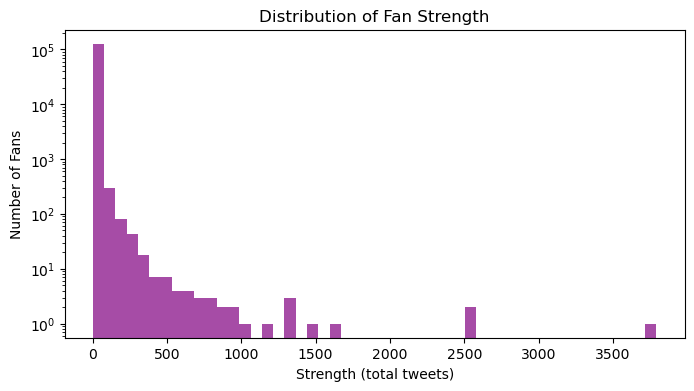

In [8]:
#kind of useless
import numpy as np
import matplotlib.pyplot as plt

# --- Compute fan degree + strength ---
fan_degree = {fan: G.degree(fan) for fan in fans}
fan_strength = {fan: sum(G[fan][club]['weight'] for club in G[fan]) for fan in fans}

degree_vals = np.array(list(fan_degree.values()))
strength_vals = np.array(list(fan_strength.values()))

print("Average fan degree:", degree_vals.mean())
print("Average fan strength:", strength_vals.mean())

# --- Scatter plot ---
plt.figure(figsize=(8,6))
plt.scatter(degree_vals, strength_vals, alpha=0.15, s=10)

plt.xlabel("Fan Degree (number of clubs mentioned)")
plt.ylabel("Fan Strength (total tweets)")
plt.title("Fan Degree vs Fan Strength")
plt.grid(alpha=0.3)
plt.yscale('log')   # very important! strength is heavy-tailed
plt.show()

# --- Optional histogram of strength ---
plt.figure(figsize=(8,4))
plt.hist(strength_vals, bins=50, color='purple', alpha=0.7)
plt.title("Distribution of Fan Strength")
plt.xlabel("Strength (total tweets)")
plt.ylabel("Number of Fans")
plt.yscale("log")
plt.show()


<Figure size 1200x600 with 0 Axes>

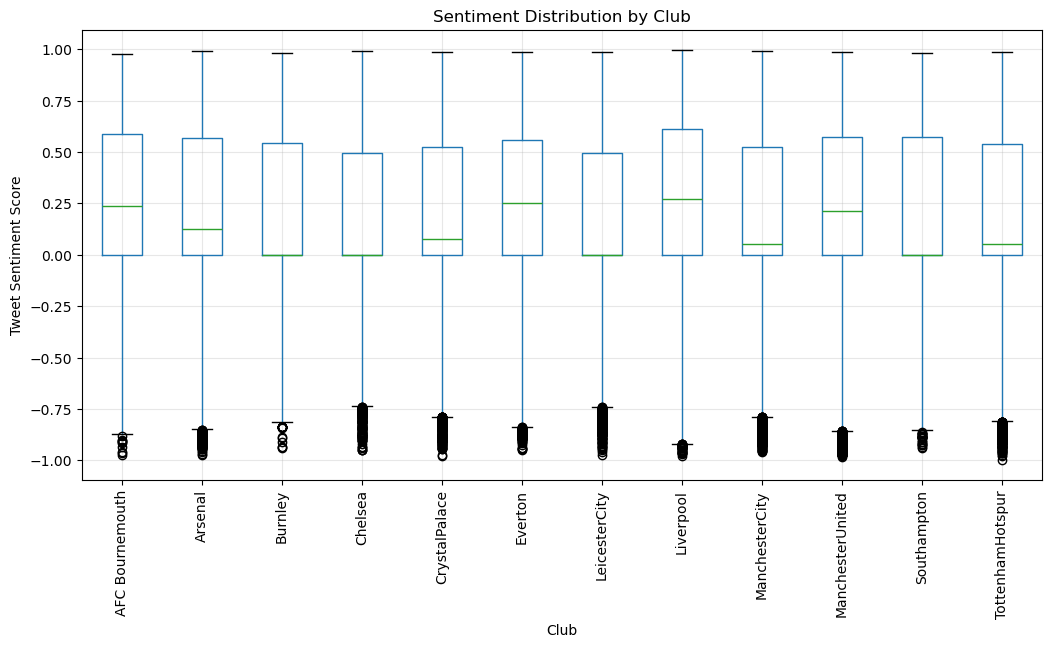

In [9]:
plt.figure(figsize=(12,6))
df.boxplot(column='sentiment', by='club', rot=90, figsize=(12,6))
plt.title("Sentiment Distribution by Club")
plt.suptitle('')
plt.xlabel("Club")
plt.ylabel("Tweet Sentiment Score")
plt.grid(alpha=0.3)
plt.show()


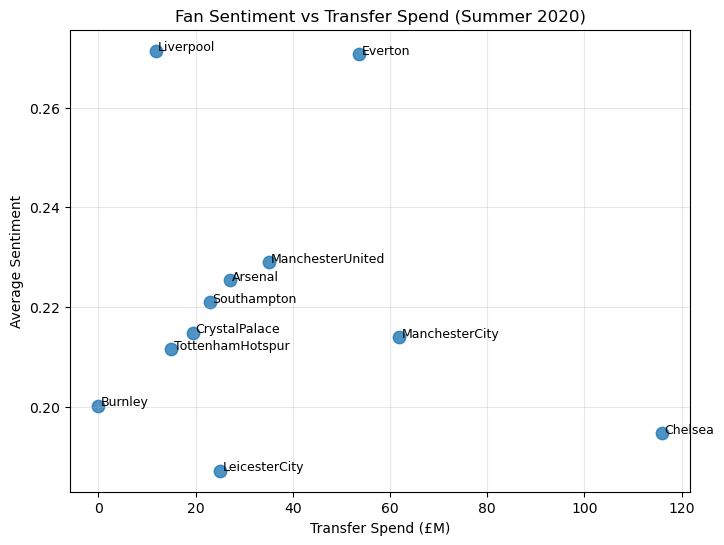

Correlation: -0.142


In [10]:
merged = merged.sort_values('spend_gbp_m')
plt.figure(figsize=(8,6))
plt.scatter(merged['spend_gbp_m'], merged['avg_sentiment'], s=80, alpha=0.8)

for _, row in merged.iterrows():
    plt.text(row['spend_gbp_m']+0.5, row['avg_sentiment'], row['club'], fontsize=9)

plt.xlabel("Transfer Spend (£M)")
plt.ylabel("Average Sentiment")
plt.title("Fan Sentiment vs Transfer Spend (Summer 2020)")
plt.grid(alpha=0.3)
plt.show()

corr = merged['spend_gbp_m'].corr(merged['avg_sentiment'])
print("Correlation:", round(corr, 3))


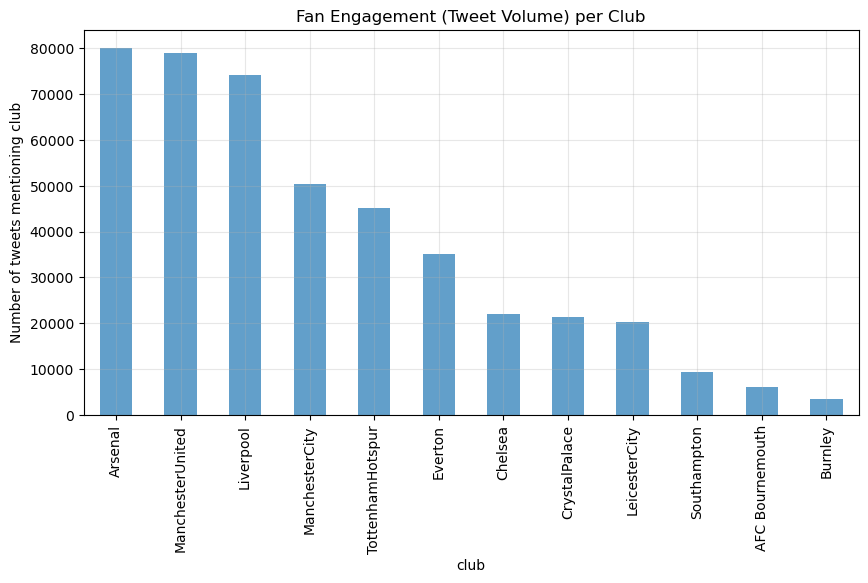

             spend_gbp_m  engagement
spend_gbp_m     1.000000   -0.040071
engagement     -0.040071    1.000000


In [11]:
club_engagement = df.groupby('club')['user'].count().sort_values(ascending=False)
plt.figure(figsize=(10,5))
club_engagement.plot(kind='bar', alpha=0.7)
plt.ylabel("Number of tweets mentioning club")
plt.title("Fan Engagement (Tweet Volume) per Club")
plt.grid(alpha=0.3)
plt.show()
merge2 = merged.merge(club_engagement.rename("engagement"), on="club")
print(merge2[['spend_gbp_m','engagement']].corr())



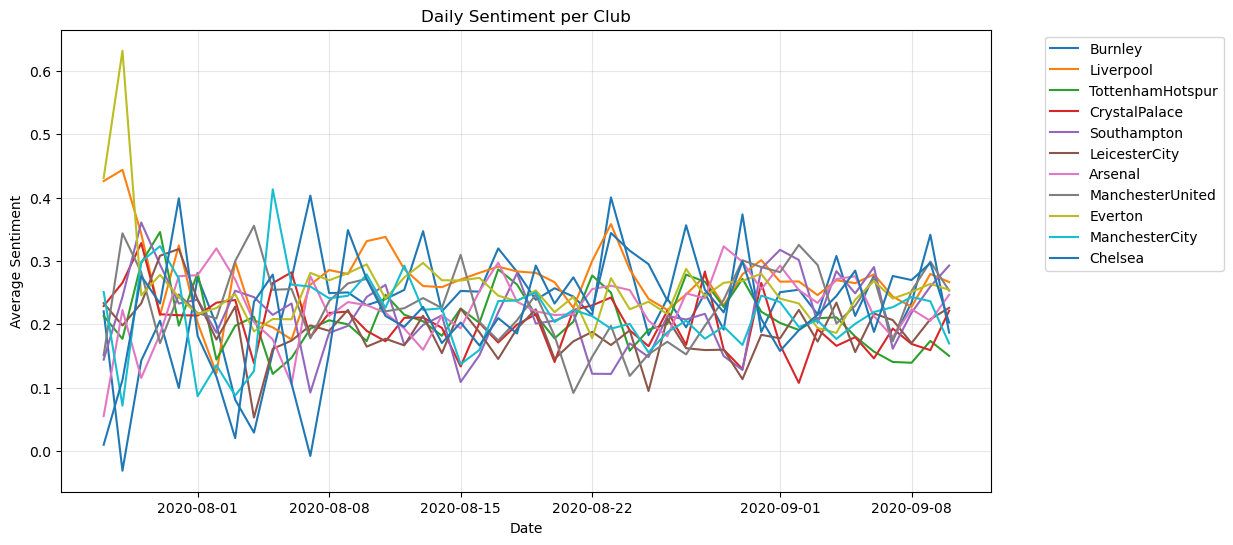

In [12]:
df['day'] = df['date'].dt.date

daily_sent = df.groupby(['club','day'])['sentiment'].mean().reset_index()

plt.figure(figsize=(12,6))
for club in merged['club'].tolist():
    subset = daily_sent[daily_sent['club'] == club]
    plt.plot(subset['day'], subset['sentiment'], label=club)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.title("Daily Sentiment per Club")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.grid(alpha=0.3)
plt.show()
